In [762]:
from os import listdir, path, errno, makedirs
from shutil import copyfile
import re
from PIL import Image, ImageStat
import numpy as np
import pandas as pd
from scipy import stats
import scipy.fftpack
import matplotlib.pyplot as plt
import cv2 as cv
import scipy.misc
from scipy import signal
%matplotlib inline

In [843]:
def normalize(img, M0=250, VAR0=100):
    I = img.copy()
    M = I.sum() / I.shape[0] / I.shape[1]
    VAR = ((I - M) ** 2).sum() / I.shape[0] / I.shape[1]
    G = -np.sqrt(VAR0 * (I - M) ** 2 / VAR)
    G[I > M] *= -1
    G += M0
    return G

In [703]:
def clrnormalize(img):
    res=img.copy()
    for i in range(res.shape[0]):
        for j in range(res.shape[1]):
            if((res[i][j][0]+res[i][j][1]+res[i][j][2])!=0):
                temp1=res[i][j][0]*255/(res[i][j][0]+res[i][j][1]+res[i][j][2])
                temp2=res[i][j][1]*255/(res[i][j][0]+res[i][j][1]+res[i][j][2])
                temp3=res[i][j][2]*255/(res[i][j][0]+res[i][j][1]+res[i][j][2])
                res[i][j][0]=temp1
                res[i][j][1]=temp2
                res[i][j][2]=temp3
    return res

In [704]:
def build_filters():
    filters = []
    ksize = 31
    for theta in np.arange(0, np.pi, np.pi/32):
        kern = cv.getGaborKernel((ksize, ksize), 5, theta, 10.0,1, 0, ktype=cv.CV_32F)
        kern /= 1.5*kern.sum()
        filters.append(kern)
    return filters

In [705]:
def process(img, filters):
    accum = np.zeros_like(img)
    for kern in filters:
        fimg = cv.filter2D(img, cv.CV_8UC3, kern)
        np.maximum(accum, fimg, accum)
    return accum

In [737]:
def func(img, n_scale,isFiltered):
    res= img.copy()
    if(isFiltered):
        res = normalize(img)
    res2 = res.reshape(-1)
    N = res2.shape[0] / n_scale
    T = 1.0 / (255 * 2)
    yf = scipy.fftpack.fft(res2)
    xf = np.linspace(0.0, 1.0 / (2.0 * T), int(N / 2))
    
    return xf[10:], (2.0 / N * np.abs(yf[:int(N / 2)]))[10:], res

In [738]:
def clrfunc(img, n_scale,isFiltered):
    res= img.copy()
    if(isFiltered):
        res = clrnormalize(img)
    res2 = res.reshape(-1)
    N = res2.shape[0] / n_scale
    T = 1.0 / (255 * 2)
    yf = scipy.fftpack.fft(res2)
    xf = np.linspace(0.0, 1.0 / (2.0 * T), int(N / 2))
    
    return xf[10:], (2.0 / N * np.abs(yf[:int(N / 2)]))[10:], res

In [739]:
def toclrmap(img,n_scale):
    res= img.copy()
    print(str(res.shape[0])+'x'+str(res.shape[1])+' : ' +str(res.shape[0]*res.shape[1])+" pixel" )
    btmap=np.zeros(res.shape[0]*res.shape[1])
    count=int(0)
    for i in range(res.shape[0]):
        for j in range(res.shape[1]):
            btmap[count]=int(res[i][j][0]//1+1000*(res[i][j][1]//1)+1000000*(res[i][j][2]//1))
            count+=1
    N = btmap.shape[0] // n_scale
    T = 1.0 / (255255255)
    yf = scipy.fftpack.fft(btmap)
    xf = np.linspace(0.0, 1.0 /T, N)
    return xf, ( 1/ N * np.abs(yf[:int(N)])), btmap

In [857]:
def histogram(img):
    table=np.zeros(300)
    for e in img:
        for i in e:
            table[int(i)]+=1
    return table

In [861]:
def quick_test(p):
    fig, axes = plt.subplots(3, 3,  figsize=(20, 5),sharey=False)
#     img = cv.imread(p, 0)
#     clr = cv.imread(p)
#     x, y, res = func(img, n_scale)
#     t = clr.reshape((clr.shape[0]*clr.shape[1], 3))
    img = cv.imread(p, 0)
    clr = cv.imread(p)
    clr=cv.cvtColor(clr,cv.COLOR_BGR2RGB)
    t = clr.reshape((clr.shape[0]*clr.shape[1], 3))
    #print(t.std(axis=0), t.mean(axis=0))
    #print(t[:, [0, 1 , 2]].mean())
    #print(t[:, [0, 1 , 2]].std(axis=0))
#     print(t[:, [0, 2]].std(axis=0),t[:, [0, 2]].std(axis=0).sum())
#     print(t[:, [1, 2]].std(axis=0),t[:, [1, 2]].std(axis=0).sum())
#     print(t[:, [0, 1]].std(axis=0),t[:, [0, 1]].std(axis=0).sum())
      
#     meanbal=img.mean()
#     print(balancer)
    fix=img.shape[0]*img.shape[1]
#     x, y, res = clrfunc(clr, 1,False)
#     axes[0,0].plot(x,y/fix)
#     x, y, res = clrfunc(clr, 1,True)
#     axes[0,1].plot(x,y/fix)
    x, y, res = func(img, 1,False)
    axes[1,0].plot(x,y/fix)
    x, y, res = func(img, 1,True)
    axes[1,1].plot(x,y/fix)
    #x,y,res = toclrmap(clr, 100)
    #axes[0,2].set_yscale("log", nonposx='clip')
    axes[2,1].plot(np.arange(300),histogram(img)/fix)
    axes[2,0].plot(np.arange(300),histogram(normalize(img))/fix)
    axes[1,2].imshow(clr)
    plt.show()

In [862]:
def showIm(p):
    fig, axes = plt.subplots(2, 2,  figsize=(10, 5),sharey=False)
    img = cv.imread(p, 0)
    clr = cv.imread(p)
    clr=cv.cvtColor(clr,cv.COLOR_BGR2RGB)
    axes[0,0].imshow(clr)
    axes[0,1].imshow(img,cmap='gray')
    axes[1,1].imshow(clrnormalize(clr))
    axes[1,0].imshow(normalize(img))
    plt.show()


# Observation
If we FFT color no normalization pic middle ages art is unique(Second peak is low)
You can detect whether resolution is high or low 

# Impressionism
แกน x ยาวกว่า ba ( เกิน x = 100 ) และ มีค่า y ช่วงต้น ประมาณ 1 ถึง 2

In [863]:
Datanum=10

d:\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in ubyte_scalars
  """
d:\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in ubyte_scalars
  
d:\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in ubyte_scalars
  import sys
d:\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in ubyte_scalars
  


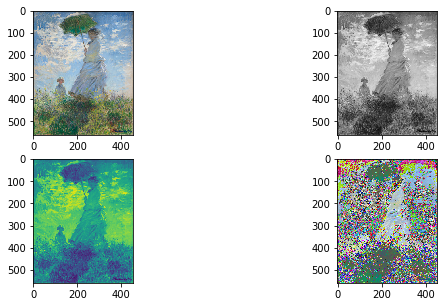

KeyboardInterrupt: 

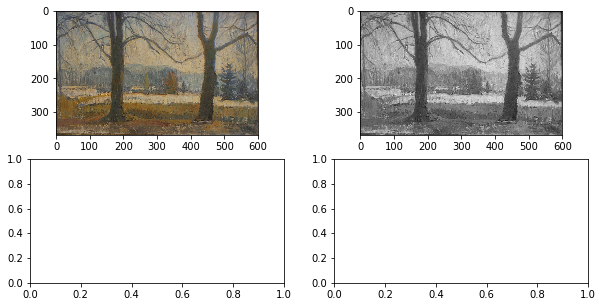

In [864]:
for i in range(1,Datanum):
    path= '/CP/Git_time/TimeSeries_mid/imp/im0'+str(i)+'.jpg'
    showIm(path)

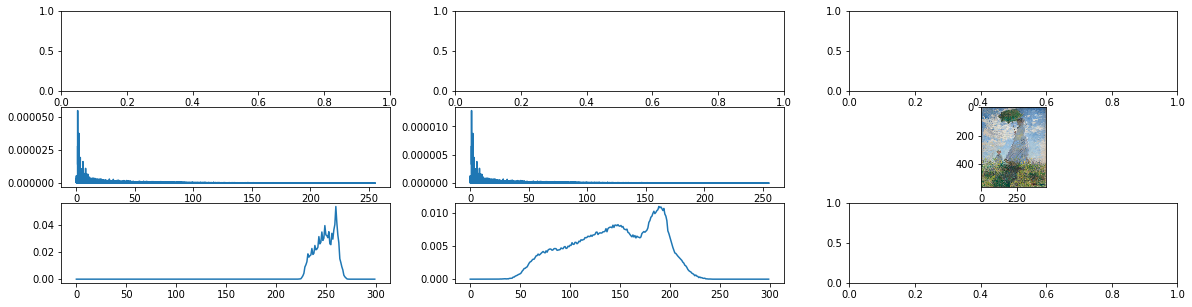

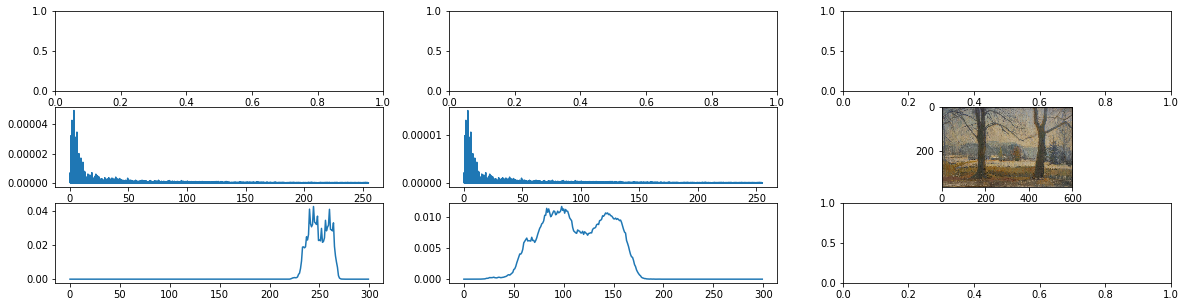

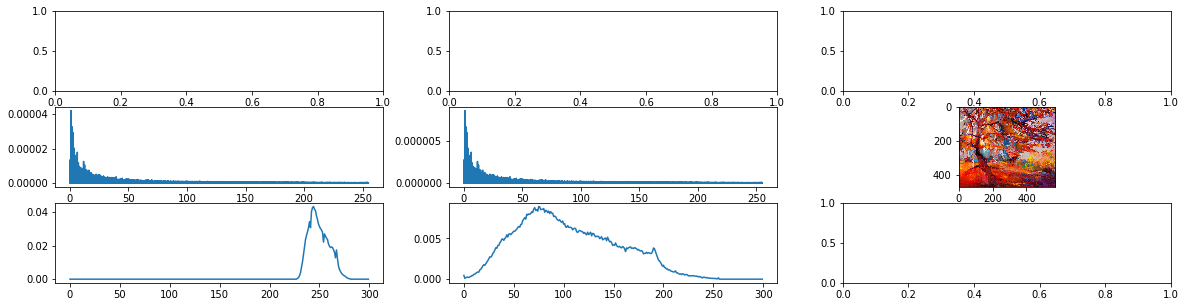

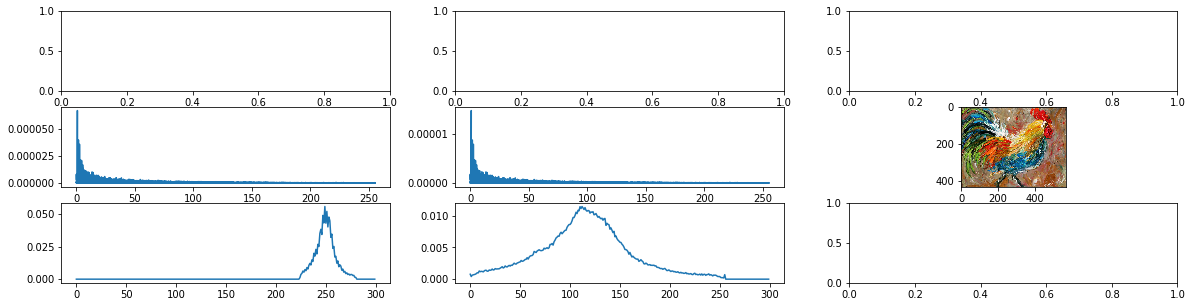

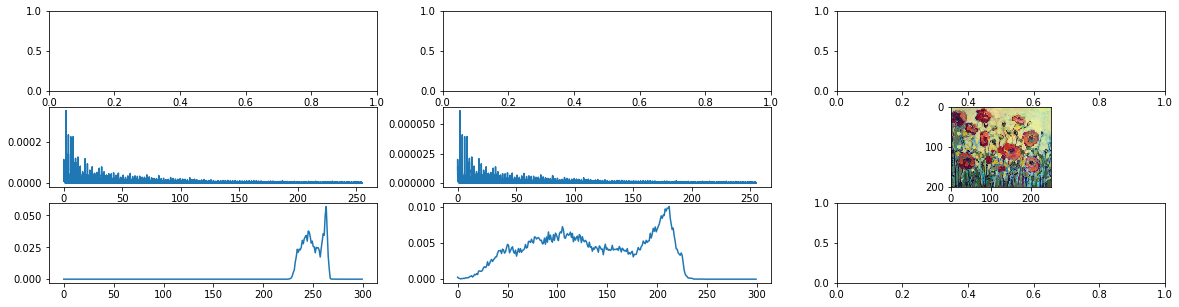

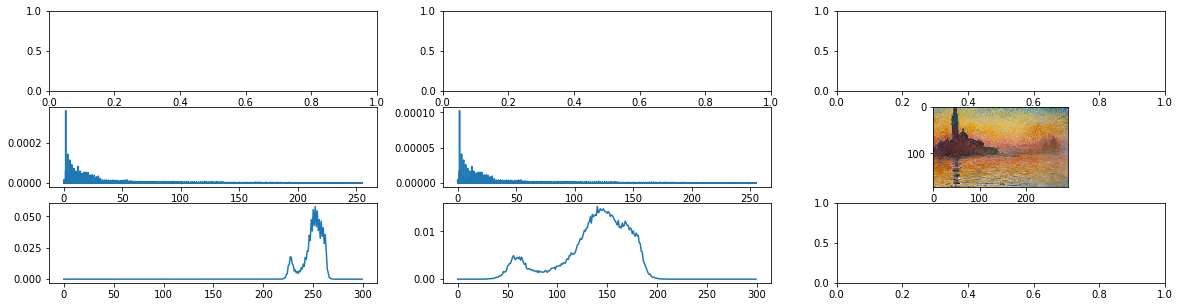

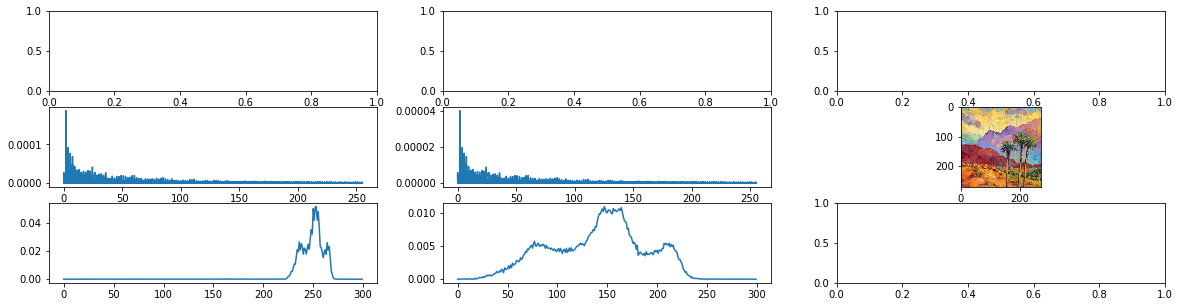

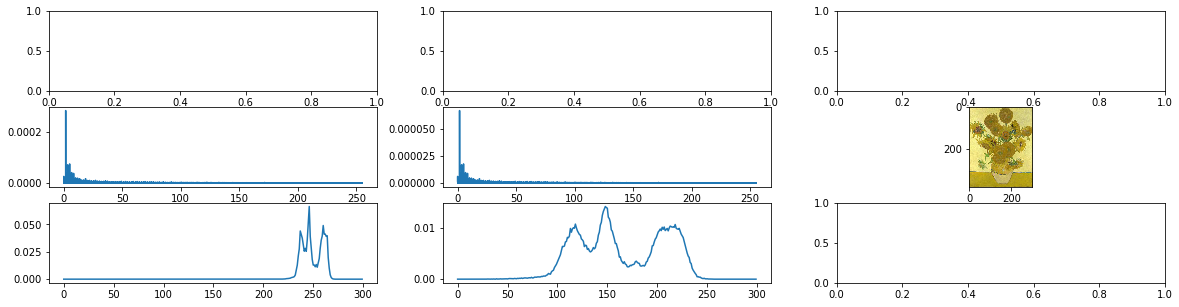

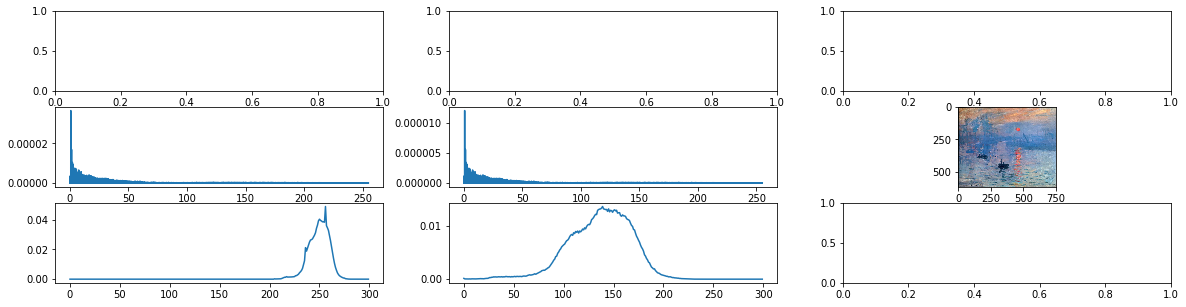

In [865]:
for i in range(1,Datanum):
    path= '/CP/Git_time/TimeSeries_mid/imp/im0'+str(i)+'.jpg'
    quick_test(path)

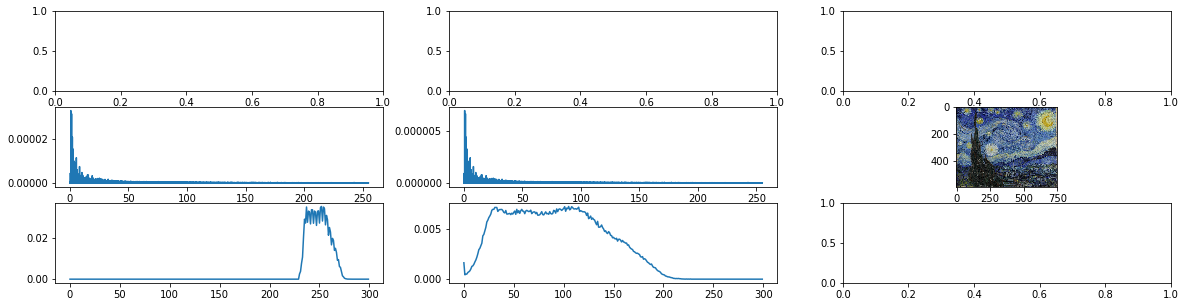

In [872]:
path= '/CP/Git_time/TimeSeries_mid/imp/im10.jpg'
quick_test(path)

# Baroque
ค่า y 2 ถึง 4 แกน x ตกที่ 50 ถึง 75

In [ ]:
for i in range(1,Datanum):
    path= '/CP/Git_time/TimeSeries_mid/ba/ba0'+str(i)+'.jpg'
    showIm(path)

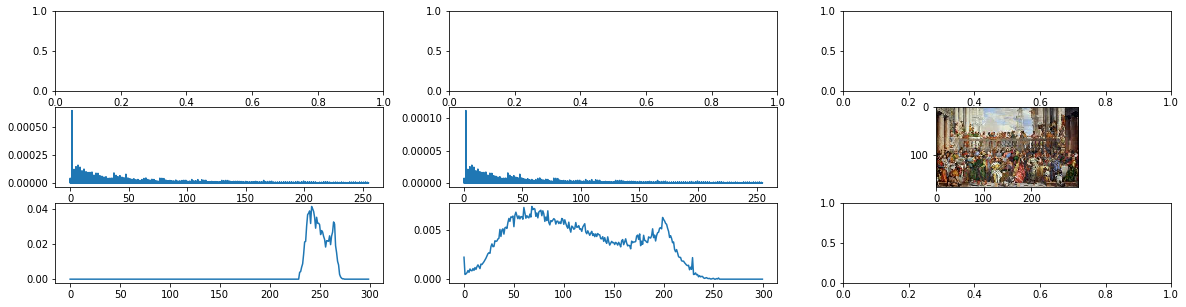

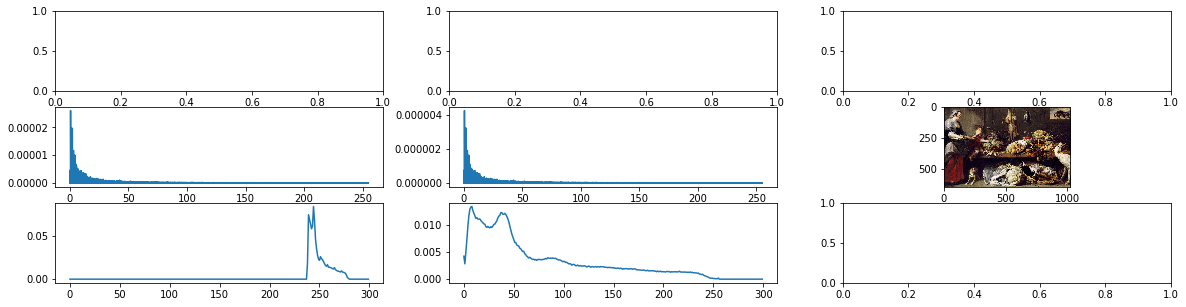

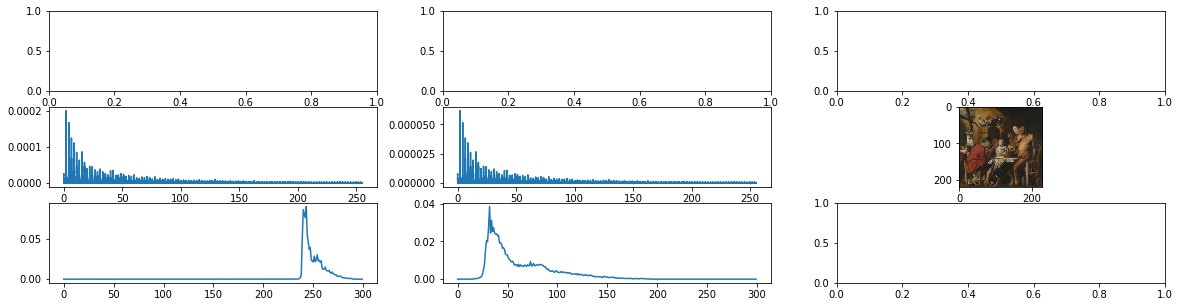

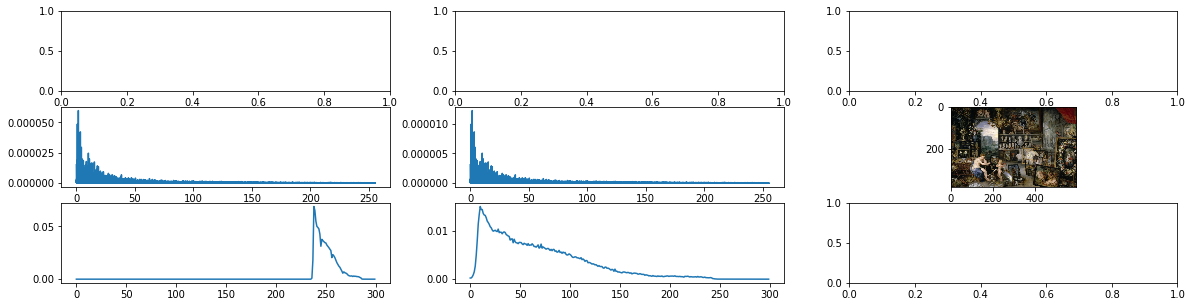

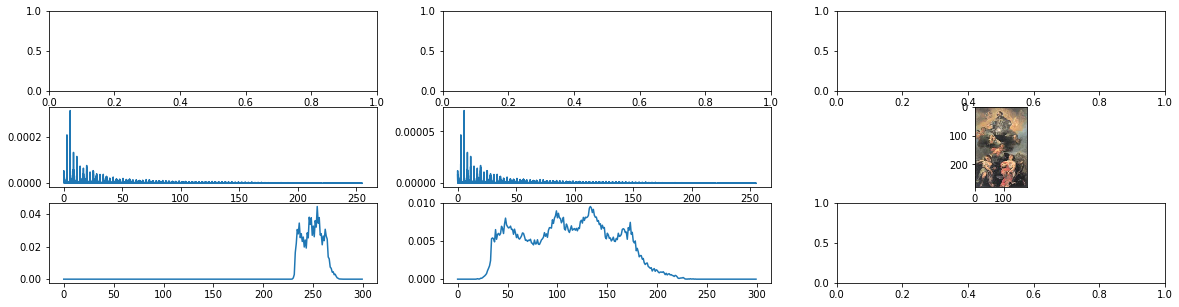

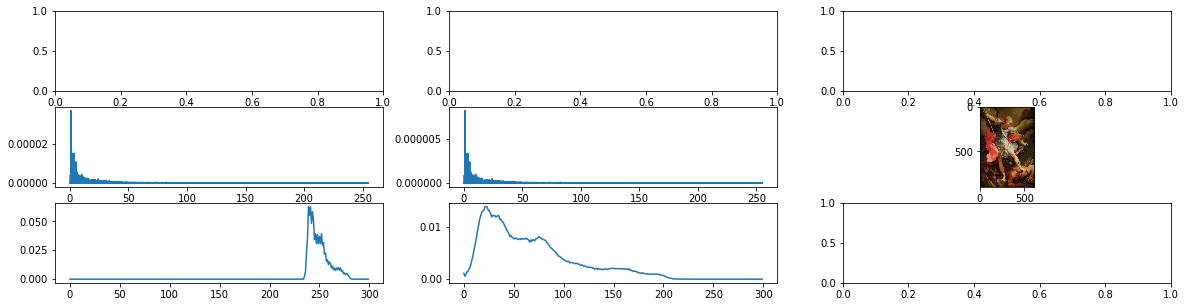

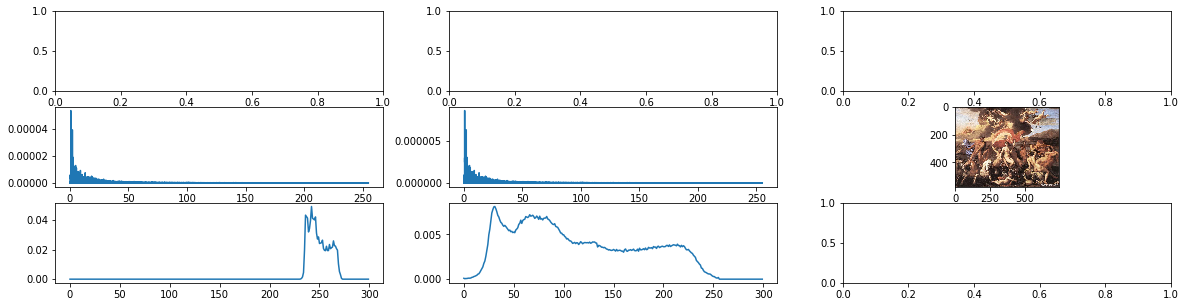

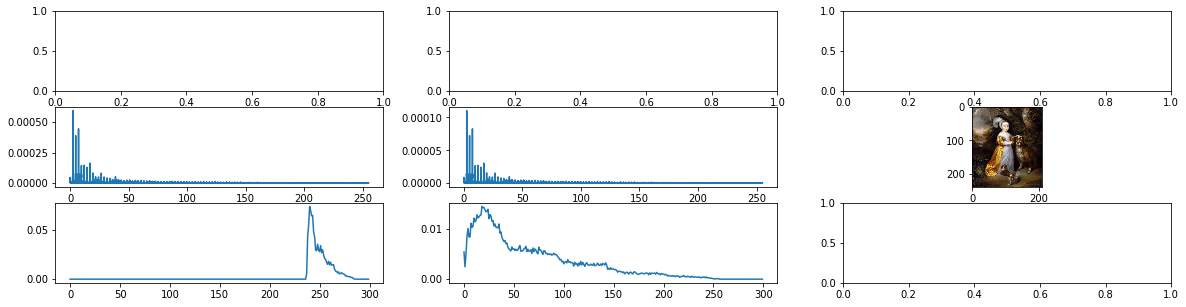

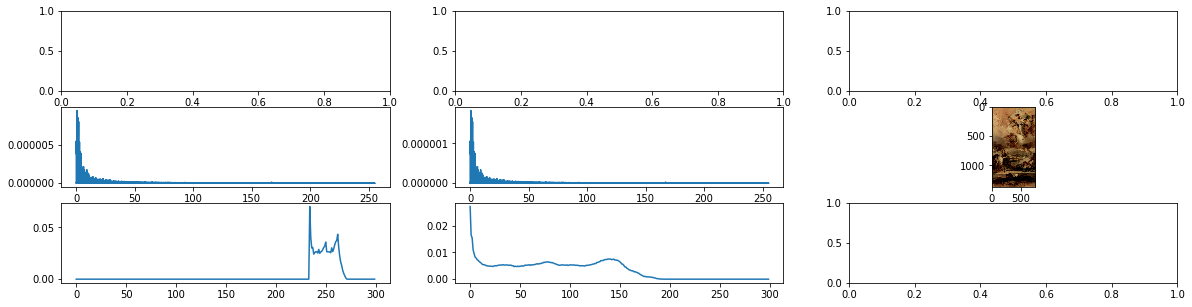

In [866]:
for i in range(1,Datanum):
    path= '/CP/Git_time/TimeSeries_mid/ba/ba0'+str(i)+'.jpg'
    quick_test(path)

# Pop Art

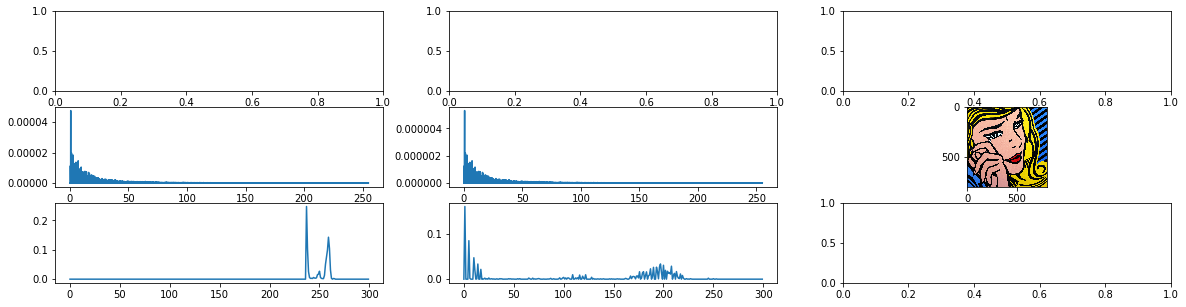

In [867]:
path= '/CP/Git_time/TimeSeries_mid/pop/p01.png' 
quick_test(path)

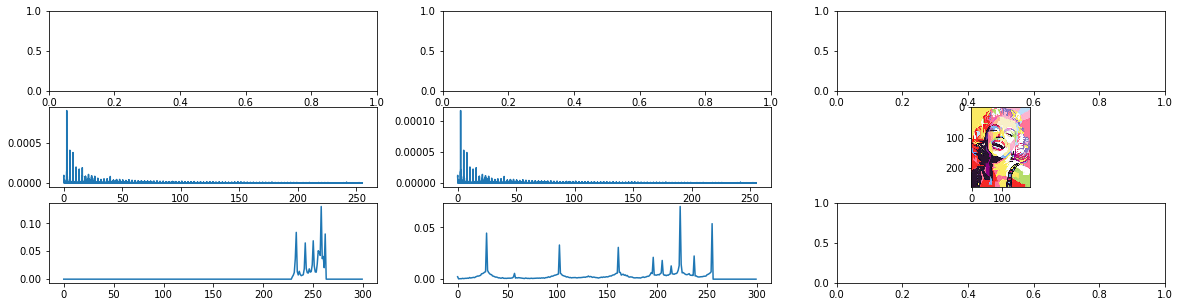

In [868]:
path= '/CP/Git_time/TimeSeries_mid/pop/p02.jpg' 
quick_test(path)

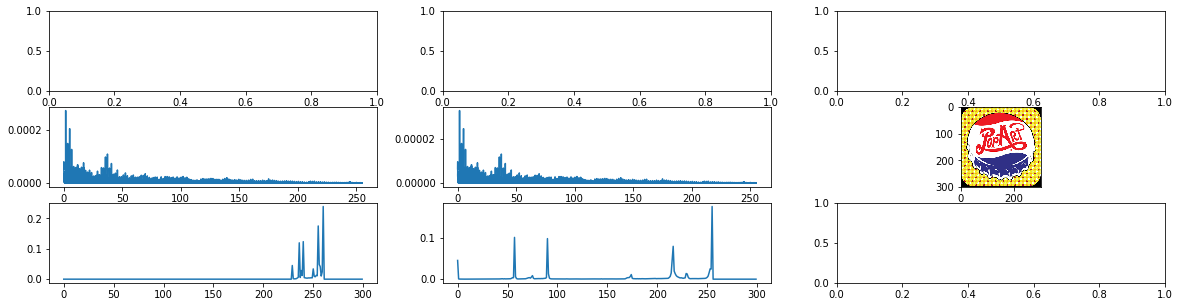

In [869]:
path= '/CP/Git_time/TimeSeries_mid/pop/p03.png' 
quick_test(path)

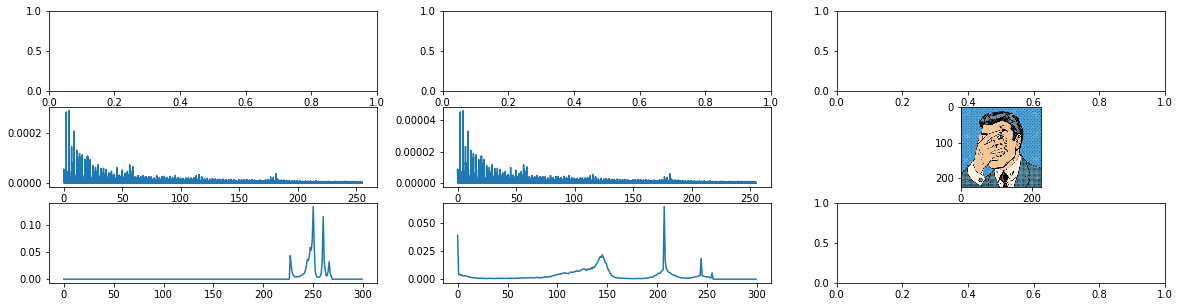

In [870]:
path= '/CP/Git_time/TimeSeries_mid/pop/p05.jpg' 
quick_test(path)

# Middle Ages

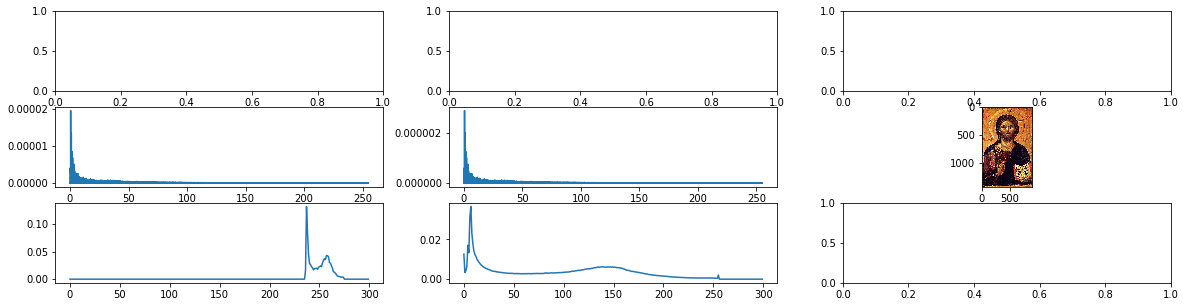

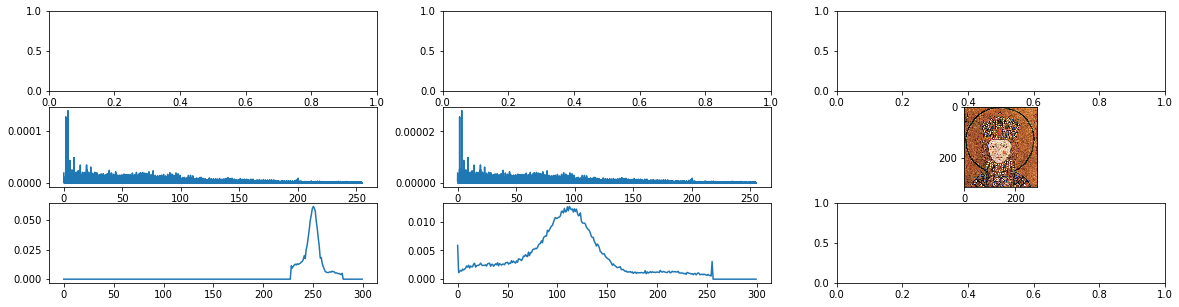

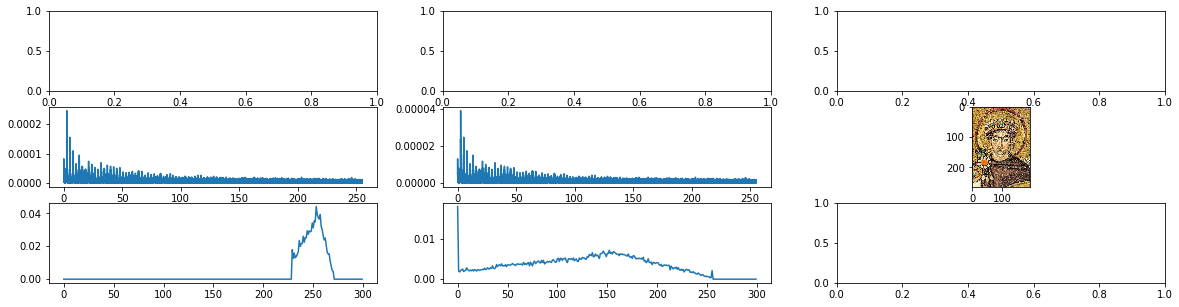

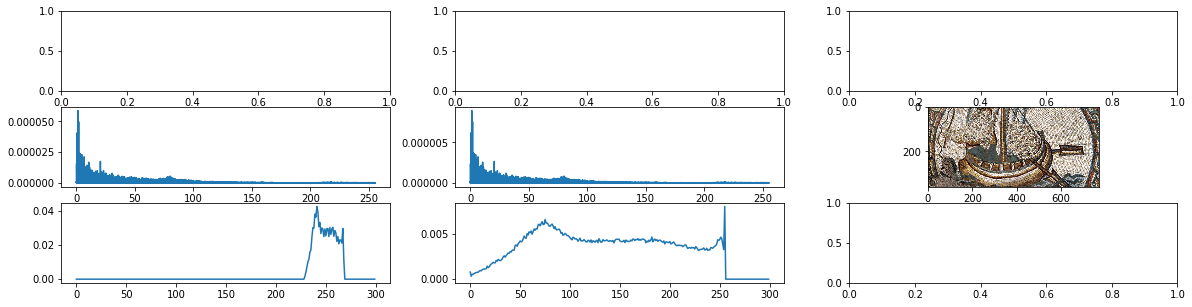

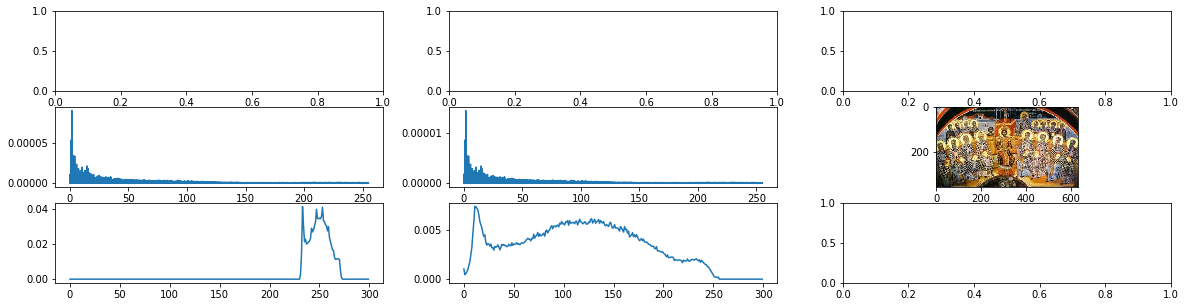

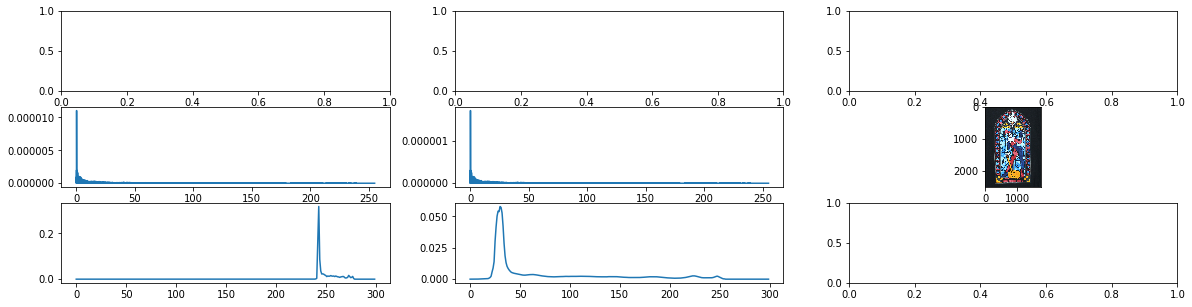

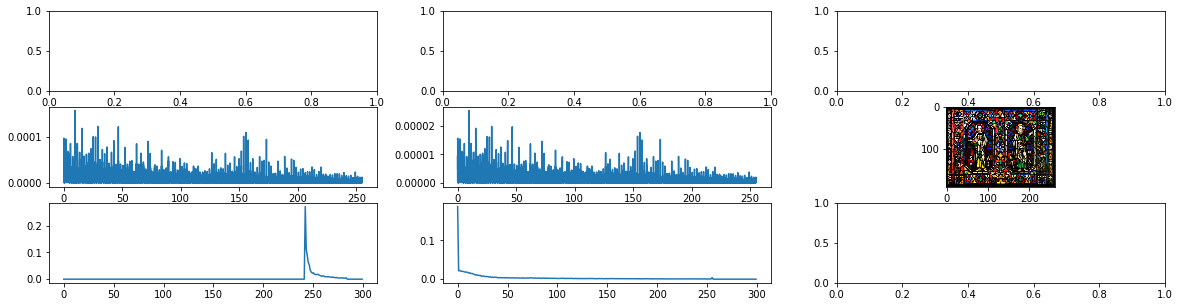

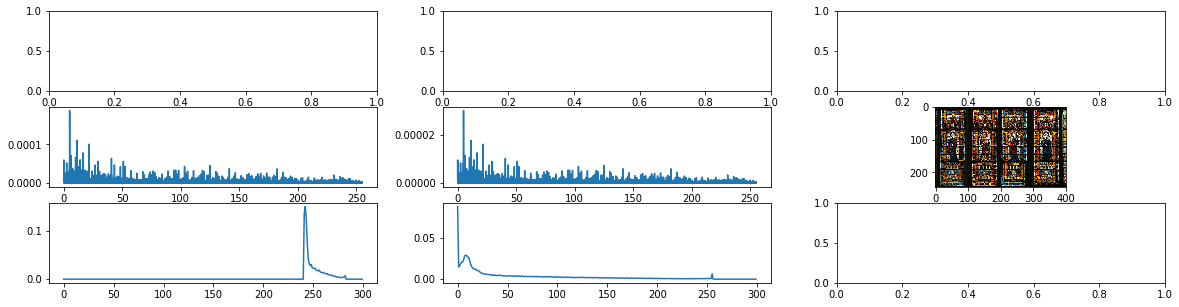

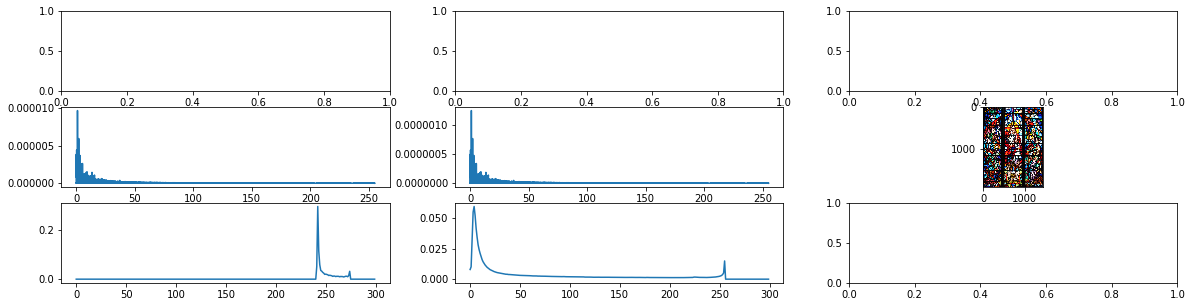

In [871]:
for i in range(1,Datanum):
    path= '/CP/Git_time/TimeSeries_mid/middle/m0'+str(i)+'.jpg'
    quick_test(path)